In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset_loader
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from skimage.io import imread_collection

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
batch_size = 100

In [2]:
def image_plot(image_vector, color):
  size = image_vector.shape[0]
  size = int(size**(1/2))
  f, ax = plt.subplots(size,size)
  for i in range(size):
    for j in range(size):
      if color:
        ax[i,j].imshow(image_vector[i*size+j].astype(np.uint8))
      else:
        ax[i,j].imshow(image_vector[i*size+j,:,:,0].astype(np.uint8), cmap='gray', vmin=0, vmax=255)

In [3]:
def image_collection_to_numpy( images ):
    images_RGB = np.zeros( (len(images),32,32,3), )

    for i in range( len(images) ):
        images_RGB[i] = images[i] 
    
    return images_RGB.astype(np.float32)

In [4]:
def transform_to_gray( images_RGB ):

    R = images_RGB[:, :, :,0]
    G = images_RGB[:, :, :,1]
    B = images_RGB[:, :, :,2]

    images_GRAY =  0.299*R  + 0.587*G + 0.114*B 

    return images_GRAY.reshape( images_RGB.shape[0],32,32,1 )

In [5]:
path_train = './../input/data-pdi/data/train/*.jpg'
path_test = './../input/data-pdi/data/test/*.jpg'

train = imread_collection(path_train)
test = imread_collection(path_test)


In [6]:
train_RGB = image_collection_to_numpy(train)
test_RGB = image_collection_to_numpy(test)

In [7]:
def shuffle_images(images_RGB):

    idx = np.arange( train_RGB.shape[0] )
    np.random.shuffle(idx)
    
    aux = np.zeros( train_RGB.shape )
    
    for i in range( train_RGB.shape[0] ):
        aux[ i, :, :, :] = images_RGB[ idx[i], :, :, :]

    return aux

In [8]:
train_RGB_t = shuffle_images(train_RGB)

In [9]:
train_GRAY = transform_to_gray(train_RGB)
test_GRAY = transform_to_gray(test_RGB)

In [10]:
def transform_in_batches(images_GRAY, images_RGB, batch_size):
    #pegando o numero de batches
    img_G_batchs = np.array(  [ images_GRAY[_ix : _ix+batch_size] for _ix in range(0, images_GRAY.shape[0], batch_size)  ]  )
    img_RGB_batchs = np.array(  [ images_RGB[_ix : _ix+batch_size] for _ix in range(0, images_RGB.shape[0], batch_size)  ]  )

    return img_G_batchs, img_RGB_batchs
    
train_GRAY_b, train_RGB_b = transform_in_batches(train_GRAY, train_RGB, batch_size)
test_GRAY_f, test_RGB_f = transform_in_batches( test_GRAY, test_RGB, batch_size )

In [11]:
def transform_and_create_torch_tensors(data, batch_size):
    
    data = torch.from_numpy(data).float().cuda()
    return data.contiguous().view(data.size(0),batch_size,-1,32,32)

In [12]:
!nvidia-smi

Mon Jun 21 22:18:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
train_GRAY_tensor = transform_and_create_torch_tensors(train_GRAY_b, batch_size)
train_RGB_tensor = transform_and_create_torch_tensors(train_RGB_b, batch_size)

test_GRAY_tensor = transform_and_create_torch_tensors(test_GRAY_f, batch_size)
test_RGB_tensor = transform_and_create_torch_tensors(test_RGB_f, batch_size)

In [14]:
MEAN = torch.mean( train_GRAY_tensor[:,:,0,:,:] )
STD = torch.mean( train_GRAY_tensor[:,:,0,:,:] )

train_GRAY_tensor[:,:,0,:,:] = (train_GRAY_tensor[:,:,0,:,:]-MEAN)/STD
train_RGB_tensor /= 255

test_GRAY_tensor[:,:,0,:,:] = (test_GRAY_tensor[:,:,0,:,:]-MEAN)/STD
test_RGB_tensor /= 255

In [15]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)

    )

    return conv

In [16]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = double_conv(1,16)
        self.conv2 = double_conv(16,32)
        self.conv3 = double_conv(32,32)
        self.linear1 = nn.Linear(32*8*8, 512)
        self.linear2 = nn.Linear(512, 3072)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, image):
        #taking batch_size
        batch_size = image.size()[0]
        # Encoder Phase
        x1 = self.conv1(image)
        x2 = self.max_pool(x1)
        
        x3 = self.conv2(x2)
        x4 = self.max_pool(x3)
        
        x5 = self.conv3(x4)
        # Decoder Phase
        x6 = self.linear1(x5.view(batch_size,-1))
        
        f1 = F.relu(x6)
        f2 = torch.sigmoid(self.linear2(f1)).view(-1, 3, 32, 32)
        return f2

In [17]:
learning_rate = 0.0001
epochs = 2000

loss = nn.MSELoss()
model = CNN()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
train_loss_array = []
test_loss_array = []
for e in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    
    for batch, train_data in enumerate(train_GRAY_tensor):
        x = train_data
        y = train_RGB_tensor[batch]
        
        optimizer.zero_grad()
        
        y_hat = model(x)
        loss_batch = loss(y_hat, y)
        train_loss += loss_batch.item()
        loss_batch.backward()
        optimizer.step()
    
    with torch.no_grad():
        for batch, test_data in enumerate(test_GRAY_tensor):
            x = test_data
            y = test_RGB_tensor[batch]
        
            y_hat = model(x)
            loss_test = loss(y_hat, y)
            test_loss += loss_test.item()
    
    train_loss_array.append(train_loss)
    test_loss_array.append(test_loss)
    print('\rEPOCH: {} | Train_loss: {} | Test_loss: {}'.format(e, train_loss, test_loss), end='')

print('\nFinished Training')

EPOCH: 1999 | Train_loss: 2.3465220669750124 | Test_loss: 1.4805386755615473
Finished Training


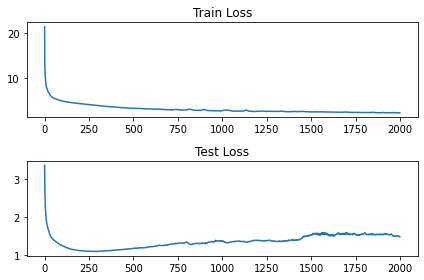

In [19]:
f, ax = plt.subplots(2,1)
ax[0].set_title('Train Loss')
ax[0].plot(train_loss_array)
ax[1].set_title('Test Loss')
ax[1].plot(test_loss_array)
f.tight_layout()
plt.show()

In [20]:
img =  model(test_GRAY_tensor[0])

In [21]:
qtd_plot = 3

imgs_gray = np.zeros( (qtd_plot*qtd_plot, 32, 32, 1) )
imgs_RGB = np.zeros( (qtd_plot*qtd_plot, 32, 32, 3) )
imgs_cnn = np.zeros( (qtd_plot*qtd_plot, 32, 32, 3) )

for i in range(qtd_plot):
    for j in range(qtd_plot):
        tmp = MEAN.item()+test_GRAY_tensor[i][j].detach().cpu().squeeze().numpy()*STD.item()
        imgs_gray[i*qtd_plot + j,:,:,:] = tmp.reshape(32,32,1).astype(np.uint8)
    
        tmp = test_RGB_tensor[i][j].detach().cpu().numpy()*255
        imgs_RGB[i*qtd_plot + j,:,:,:] = tmp.reshape(32,32,3).astype(np.uint8)
    
        tmp = model(test_GRAY_tensor[i])[j].detach().cpu().numpy()*255
        imgs_cnn[i*qtd_plot + j,:,:,:] = tmp.reshape(32,32,3).astype(np.uint8)

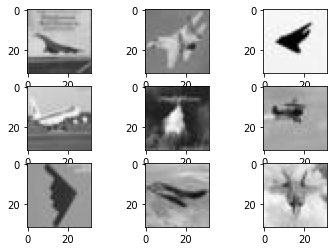

In [22]:
image_plot(imgs_gray, 0)

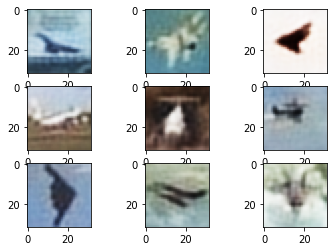

In [23]:
image_plot(imgs_cnn, 1)

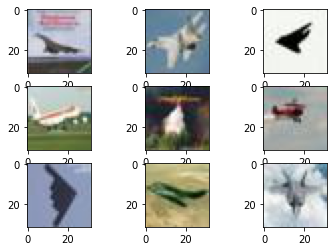

In [24]:
image_plot(imgs_RGB, 1)